In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
# inline plotting
%matplotlib inline

In [3]:
from labproject.experiments import Experiment, ScaleDim, ScaleSampleSize
from labproject.utils import get_log_path

In [4]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.metrics import METRICS
from torch.distributions import MultivariateNormal


In [5]:
from labproject.plotting import generate_palette
color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleSampleSizeKL':'kl', 'ScaleSampleSizeSW':'wasserstein',
           'ScaleSampleSizeMMD':'mmd', 'ScaleSampleSizeC2ST':'c2st',
           'ScaleSampleSizeFID':'fid', }


# All multiple datasets

Running experiments...
Seed: 0
Experiments: ['ScaleSampleSizeSW', 'ScaleSampleSizeC2ST', 'ScaleSampleSizeMMD', 'ScaleSampleSizeFID']
Data: ['imagenet_real_embeddings']
imagenet_real_embeddings 10000 2048
Experiment ScaleSampleSizeSW finished in 0.18105506896972656
Numerical results saved to results/embedding_samplesize/embed_samplesize_SW_imagenet_real_embeddings_0_.pkl
Experiment ScaleSampleSizeSW finished in 0.3677103519439697
Numerical results saved to results/embedding_samplesize/embed_samplesize_SW_imagenet_real_embeddings_1_.pkl
Experiment ScaleSampleSizeC2ST finished in 262.286119222641
Numerical results saved to results/embedding_samplesize/embed_samplesize_C2ST_imagenet_real_embeddings_0_.pkl
Experiment ScaleSampleSizeC2ST finished in 608.0215785503387
Numerical results saved to results/embedding_samplesize/embed_samplesize_C2ST_imagenet_real_embeddings_1_.pkl
MMD
Experiment ScaleSampleSizeMMD finished in 4.929630279541016
Numerical results saved to results/embedding_samplesiz

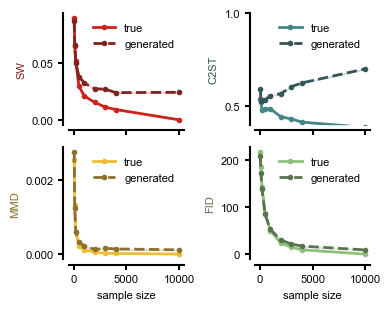

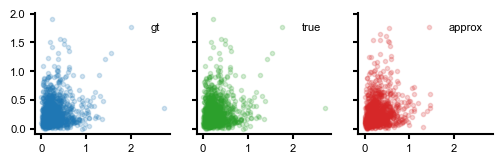

In [8]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.utils import get_cfg, set_seed, get_log_path
from labproject.data import get_dataset
import os
from omegaconf import OmegaConf
from labproject.experiments import *
from labproject.plotting import cm2inch
import time
import datetime
import pickle
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal


print("Running experiments...")
# load the config file
cfg = OmegaConf.load("../../configs/conf_embedding_samplesize.yaml") 
cfg.running_user = 'embedding_samplesize'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")


col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]

color_list = [col_light, col_dark] # make this a list to account for true and shifted

label_true = {}
label_shift = {}
for e, data_name in enumerate(cfg.data):
    label_true[data_name] = "true"
    label_shift[data_name] = "generated"
    
label_list = [label_true, label_shift]
label_list[1]['toy_2d'] = 'approx.'
label_list[1]['random'] = 'shifted'
mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
        'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
        'ScaleSampleSizeFID':'FID', }

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# make comparison plots
fig, axes = plt.subplots(2, 2, figsize=cm2inch((10, 8)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

sample_sizes=[50, 100, 200, 500, 1000, 2000, 3000, 4000, 10000]
#sample_sizes=[50, 100, 200,]

for dd, ds in enumerate(cfg.data):
    # if cfg.data[dd] != 'imagenet_real_embeddings':
    #     continue
    dataset_fn = get_dataset(cfg.data[dd])
    n_samples = cfg.n[dd]
    
    dataset_gt = dataset_fn(n_samples,cfg.d[dd])
    dataset_intra = dataset_fn(n_samples,cfg.d[dd])
    
    print(cfg.data[dd], n_samples, cfg.d[dd])
    
    if cfg.data[dd] == 'toy_2d':
        dataset_inter = MultivariateNormal(torch.mean(dataset_gt, axis=0).T,
                                           torch.cov(dataset_gt.T)).sample((n_samples,))
    elif cfg.data[dd] == 'random' and cfg.augmentation[dd]=='mean_shift':
        dataset_inter = dataset_gt + 1
    elif cfg.data[dd] == 'random' and cfg.augmentation[dd]=='one_dim_shift':
        # just shift the first dimension by 0.1
        dataset_inter = dataset_gt.clone()
        dataset_inter[:,0] += 1
    elif cfg.data[dd] == 'imagenet_real_embeddings':
        dataset_fn = get_dataset(cfg.augmentation[dd])        
        dataset_inter = dataset_fn(n_samples,cfg.d[dd])

    fig_data, axes_data = plt.subplots(1, 3, figsize=cm2inch((15, 4)), sharex=True, sharey=True)
    axes_data[0].plot(dataset_gt[:1000, 0], dataset_gt[:1000, 1], 'o', label='gt', alpha=0.2, color='C0')
    axes_data[1].plot(dataset_intra[:1000, 0], dataset_intra[:1000, 1], 'o', label='true',  alpha=0.2, color='C2')
    axes_data[2].plot(dataset_inter[:1000, 0], dataset_inter[:1000, 1], 'o', label='approx' ,alpha=0.2, color='C3')
    for ax in axes_data:
        ax.legend()

    
    for e, exp_name in enumerate(cfg.experiments):
        experiment = globals()[exp_name]()
        time_start = time.time()
        dataset1 = dataset_gt
        ax = axes.flatten()[e]
        for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
            dataset2 = data_comp
            assert dataset1.shape == dataset2.shape, f"Dataset shapes do not match: {dataset1.shape} vs. {dataset2.shape}"
            
            if mapping[exp_name]  == 'MMD':
                print('MMD')
                output = experiment.run_experiment(dataset1=dataset1,
                                                dataset2=dataset2,
                                                sample_sizes=sample_sizes,
                                                nb_runs = 1, bandwidth=50)
            else:
                output = experiment.run_experiment(dataset1=dataset1,
                                                    dataset2=dataset2,
                                                    sample_sizes=sample_sizes,
                                                    nb_runs = 1)
            time_end = time.time()
            print(f"Experiment {exp_name} finished in {time_end - time_start}")

            log_path = get_log_path(cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_{dc}", timestamp=False)
            os.makedirs(os.path.dirname(log_path), exist_ok=True)
            experiment.log_results(output, log_path)
            print(f"Numerical results saved to {log_path}")

            experiment.plot_experiment(*output, cfg.data[dd],
                                    ax=ax,
                                    color=color_list[dc][exp_name], #generate_palette(color_dict[col_map[exp_name]])[col_idx], #col_dict[dc][mapping[exp_name]], 
                                    label=label_list[dc][cfg.data[dd]],#'true' if dc == 0 else 'approx.',
                                    linestyle='-' if dc == 0 else '--',lw=2, marker='o')
            ax.set_ylabel(mapping[exp_name])
            ax.set_xlabel('')
            if mapping[exp_name]  == 'C2ST':
                ax.set_ylim([0.40,1])
                ax.set_yticks([0.5,1])
            
        ax.legend()
    
axes[-1,0].set_xlabel('sample size')
axes[-1,1].set_xlabel('sample size')

fig.tight_layout()
print(f"Plots saved to {cfg.data}.png")
fig.savefig(f"./results/plots/metric_comparison_sample_size_{cfg.data}_only_embed.png", dpi=300)
fig.savefig(f"./results/plots/metric_comparison_sample_size_{cfg.data}_only_embed.pdf", dpi=300)

print("Finished running experiments.")